### Import the Neccessary Libraries

In [1]:
"""
Learning Rate = 0.001
Number of Convolutional Layers = 6
Dropout = 0.8
Gray Scale
"""
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from random import shuffle
from heapq import nlargest

# import tensorflow as tf
print("Importing TF Learn....")
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
print("\n\nDone !")

Importing TF Learn....
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


Done !


### Define the Paths to the relevant Data Sets and Files

In [2]:

TRAIN_DIR = r"E:\Masters\Datasets\Maritime_Traffic_Detection\Training_set\sc5\\"
TEST_DIR = r"E:\Masters\Datasets\Maritime_Traffic_Detection\Testing_set\sc5"
GROUND_TRUTH = r"E:\Masters\Datasets\Maritime_Traffic_Detection\Testing_set\ground_truth.txt"
DB_info = r"E:\Masters\Datasets\Maritime_Traffic_Detection\Training_set\sc5\DBinfo.txt"

#IMG_WIDTH = 400
IMG_WIDTH = 120
IMG_HEIGHT = 120
LEARN_RATE = 0.001

MODEL_NAME = "boatClassifier-{}-{}".format(LEARN_RATE, "6conv-0.001LR-GrayS-8-wtf2")

### Explore the MarDCT Database

In [3]:
# Explore the Boats Training Data Set to check for the available classes
training_classes = [f.name for f in os.scandir(TRAIN_DIR) if f.is_dir()]
#numerical_training_classes = [training_classes.index(t) for t in training_classes]
#numerical_training_classes = [i for i in range(len(training_classes))]
###print("\nClasses present in the Training Data are:", training_classes)
#print("\nTransform Classes present in the Training Data into Numbers as such:", numerical_training_classes)

# Explore the Boats Testing Data Set to check for the available classes
test_data_dict = dict()
freq_of_each_class = dict()
classes = list()
testing_classes = list()

###print("Opening the Ground Truth File and Reading its contents.....")
with open(GROUND_TRUTH, 'r') as f:
    f_content = f.read().splitlines()
for line in f_content:
    filename, label = line.split(";")
    label = label.replace(" ", "")  # Format the class label by removing spaces
    label = label.replace(":", "")  # Format the class label by removing colons " : "
    classes.append(label)
    if label not in testing_classes:
        testing_classes.append(label)
    # print("Filename: ", filename)
    # print("Label: ", label)
###print("\nClasses present in the Testing Data are: ", testing_classes)

# Count the frequency of occurrence of each class/label in the Testing Data Set
for cls in classes:
    freq_of_each_class[cls] = freq_of_each_class.get(cls, 0) + 1
# print("\nTotal Number of files in the Testing Dataset: ", len(classes))
# print("\nFrequency of Occurrence of each Class in the Testing Data Set is: ", freq_of_each_class)


### Find the Common Classes between the MarDCT Testing and Training Data Sets with the most images

In [4]:
# Find the Common Classes
#common_classes1 = list(set(training_classes).intersection(testing_classes))
common_classes = [element for element in training_classes if element in testing_classes]
###print("\nThe common classes are: ", common_classes)
#print("\nThe other method of computing common classes are: ", common_classes1)
freq_of_common_class = dict()
for cls in classes:
    if cls in common_classes:
        freq_of_common_class[cls] = freq_of_common_class.get(cls, 0) + 1
###print("\nThe Frequency of occurrence of the common classes in the testing data set", freq_of_each_class)
# Pick 3 Classes with the most number of images from the common Classes
counts = nlargest(3, freq_of_common_class.values())
classes_to_be_considered = [key for key, value in freq_of_common_class.items() if value in counts]
###print("The 3 Common Classes that have a total number of images are: ", counts)
###print("The 3 Common Classes that have the highest number of images are: ", classes_to_be_considered)
###print("\nClasses that will be considered: ", classes_to_be_considered)
# Transform labels from a list of strings to a list of Numbers
numerical_form_classes = np.asarray([classes_to_be_considered.index(t) for t in classes_to_be_considered])
###print("\nClasses that will be considered in Numerical form: ", numerical_form_classes)
classes_onehot = preprocessing.OneHotEncoder(sparse=False).fit_transform(numerical_form_classes.reshape(-1, 1))
###print("One hot vector of Classes that will be considered is", classes_onehot)
# Dictionary with Class name and Corresponding label
corres_label = dict(zip(classes_to_be_considered, classes_onehot))
print("\nDictionary with Class name and Corresponding label", corres_label)



Dictionary with Class name and Corresponding label {'VaporettoACTV': array([ 1.,  0.,  0.]), 'Mototopo': array([ 0.,  1.,  0.]), 'Lanciafino10mBianca': array([ 0.,  0.,  1.])}


### Build the Training Set that we will use to train and test the CNN

In [5]:
# Build the model's Training Data set
training_data = []
readable_training_data = []
for folder in training_classes:
    if folder in classes_to_be_considered:
        path = TRAIN_DIR + folder
        files = os.listdir(path)
        # print(files)
        # print(len(files))
        # print(folder)
        for img in files:
            img1 = img
            label1 = folder
            label = corres_label[folder]
            #print("In the training data set My label is", label)
            #print("Its Type is", type(label))
            #print("Its Shape is", label.shape)
            img_path = os.path.join(path, img)  # Build path to each Image so that we can open it
            img = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (IMG_HEIGHT, IMG_WIDTH)) # Read Image and resize it
            training_data.append([np.array(img), np.array(label)])
            readable_training_data.append([img1, label1])
shuffle(training_data)
training_data = np.asarray(training_data)
readable_training_data = np.asarray(readable_training_data)
# np.save("train_data.npy", training_data)
# np.save("readable_training_data.npy", readable_training_data)

###print("\nTraining Data Set:", training_data)
###print("\nTraining Data Set Shape/Dimensions:", training_data.shape)
###print("\nA 'Readable' form of the Training Data Set:", readable_training_data)
###print("\nReadable Training Data Set Shape/Dimensions matches the original Dataset:", readable_training_data.shape)
###print("\nThe First column comprises the images (Here are the first 5):", training_data[:5,0])
###print("\nThe Second column comrpises the labels (Here are the first 5):", training_data[:5,1])
###print("\nA given row in the Training data set has 2 Elements:", (training_data[0]).shape)
###print("\nA given row in the Training data set looks like this: ", training_data[0])
###print("\nThe first element of a given row in the Training Data Set is the image: ", training_data[0][0])
###print("\nThe second element of a given row in the Training Data Set is the label in One-hot vector form: ", training_data[0][1])
###cv2.imshow("From T D",training_data[0][0])
###cv2.waitKey(0)


### Build the Testing Set that we will feed the CNN

In [6]:
# Build the Testing Data Set
considered_test_filenames = list()
considered_test_labels = list()

with open(GROUND_TRUTH, 'r') as f:
    f_content = f.read().splitlines()
for line in f_content:
    filename, label = line.split(";")
    label = label.replace(" ", "")  # Format the class label by removing spaces
    label = label.replace(":", "")  # Format the class label by removing colons " : "
    if label in classes_to_be_considered:
        considered_test_filenames.append(filename)
        considered_test_labels.append(corres_label[label])

testing_corres_label = dict(zip(considered_test_filenames, considered_test_labels))
# print("\nDictionary with Image name and Corresponding label", testing_corres_label)

# Building the model's testing data set
testing_data = []
for test_img in os.listdir(TEST_DIR):
    if test_img == "Thumbs.db":
        continue
    # print("That test_img variable is:", test_img)
    # print("The TYPE of that test_img variable is:", type(test_img))
    if test_img in testing_corres_label.keys():
        test_data_label = testing_corres_label[test_img]
        test_img_path = os.path.join(TEST_DIR, test_img)
        test_img = cv2.resize(cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE), (IMG_HEIGHT, IMG_WIDTH))  # Read Image and resize it
        # print("Resize Successful")
        # print(test_data_dict[test_img])
        # training_data.append([np.array(img), np.array(label)])
        testing_data.append([np.array(test_img), (test_data_label)])
        # test_label =
        # "The 'img variable is the name of the file
shuffle(testing_data)
testing_data = np.asarray(testing_data)
#print("\n Testing Data Set:", testing_data)
#print("\n Testing Data Set Shape/Dimensions:", testing_data.shape)
max_length = min(training_data.shape[0], testing_data.shape[0])
###print("Max Length is", max_length)


### Build the CNN using TF Learn that has:
1. Input Layer
2. 6 Convolution + Max Pooling Layers
3. 1 Fully Connected Layer
4. 1 Output Layer

In [7]:
# Build the model and train it
# tf.reset_default_graph()
print("\n\nBuilding the CNN....\n\n")

convnet = input_data(shape=[None, IMG_WIDTH, IMG_HEIGHT, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# You have 2 fully connected layers here
# One is the fully connected and the other is the o/p layer
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 3, activation='softmax') # Outplut layer
convnet = regression(convnet, optimizer='adam', learning_rate=LEARN_RATE, loss='categorical_crossentropy', name='targets')
# Experiment changing the learning rate and
model = tflearn.DNN(convnet, tensorboard_dir='log')

print("\n\nDone Building the CNN !")




Building the CNN....


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Done Building the CNN !


In [8]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("Model Loaded!")
else:
    print("\n\nTraining the CNN....\n\n")
    model.fit({'input': X}, {'targets': Y}, n_epoch=35, validation_set=({'input': x_test}, {'targets': y_test}),
    snapshot_step=50, show_metric=True, run_id=MODEL_NAME)
    model.save(MODEL_NAME)
    print("Model Trained and Saved!")
    

INFO:tensorflow:Restoring parameters from E:\Masters\First_Semester\Machine_Learning\Lecture_Code\TF_Intro\6LayerCNN\boatClassifier-0.001-6conv-0.001LR-GrayS-8-wtf2
Model Loaded!


### Ensure Training and Testing Data are of the right Shape & Size

In [9]:
# Prepare the Testing and Training Data that will be used to train the Network
train = training_data[-max_length:]  # Training Data will be: The first N samples where N is the size of the (smaller testing data set)
test = testing_data                  # Testing Data will be as is

X = np.array([i[0] for i in train]).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
Y = [i[1] for i in train]

x_test = np.array([i[0] for i in test]).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
y_test = [i[1] for i in test]


###print("\nX_Train comprises the images (Here are the first 5):", X[:5])
###print("\nX_Test comprises the images (Here are the first 5):", x_test[:5])
###print("\nY_Train comrpises the labels (Here are the first 5):", Y[:5])
###print("\nY_Test comrpises the labels (Here are the first 5):", y_test[:5])


###print("\nThe first element is the image: ", X[0])
###print("\nThe first element is the image: ", x_test[0])
###cv2.imshow("From X", X[0])
###cv2.waitKey(0)
###cv2.imshow("From X Test", x_test[0])
###cv2.waitKey(0)
###print("\nThe second element in a given row is the label in One-hot vector form: ", Y[0])
###print("\nThe second element in a given row is the label in One-hot vector form: ", y_test[0])


###cv2.imshow("Images from the Training Data set", X[0])
###cv2.waitKey(0)
###cv2.imshow("Images from the Training Data set", X[1])
###cv2.waitKey(0)
###cv2.imshow("Images from the Training Data set", X[2])
###cv2.waitKey(0)
###cv2.imshow("Images from the Training Data set", X[3])
###cv2.waitKey(0)
###cv2.imshow("Images from the Training Data set", X[4])
###cv2.waitKey(0)
###cv2.imshow("Images from the Training Data set", X[5])
###cv2.waitKey(0)
###cv2.imshow("Images from the Testing Data set", x_test[0])
###cv2.waitKey(0)
###cv2.imshow("Images from the Testing Data set", x_test[1])
###cv2.waitKey(0)
###cv2.imshow("Images from the Testing Data set", x_test[2])#
#cv2.waitKey(0)
#cv2.imshow("Images from the Testing Data set", x_test[3])
#cv2.waitKey(0)
#cv2.imshow("Images from the Testing Data set", x_test[4])
#cv2.waitKey(0)


# print(X)
# print(Y)
# print(x_test)
# print(y_test)

#print("Shape of X Train",X.shape)
##print("Shape of Y Train",len(Y))
#print("Shape of X Test",x_test.shape)
#print("Shape of Y Test",len(y_test))


### Output the Model Predictions for 12 images

Model Predicts This image to be of class: Lanciafino10mBianca
The Correct Label is:  VaporettoACTV
Model Predicts This image to be of class: VaporettoACTV
The Correct Label is:  VaporettoACTV
Model Predicts This image to be of class: Mototopo
The Correct Label is:  Mototopo
Model Predicts This image to be of class: Mototopo
The Correct Label is:  Mototopo
Model Predicts This image to be of class: Lanciafino10mBianca
The Correct Label is:  Lanciafino10mBianca
Model Predicts This image to be of class: Lanciafino10mBianca
The Correct Label is:  Lanciafino10mBianca
Model Predicts This image to be of class: Mototopo
The Correct Label is:  Mototopo
Model Predicts This image to be of class: VaporettoACTV
The Correct Label is:  VaporettoACTV
Model Predicts This image to be of class: Mototopo
The Correct Label is:  Mototopo
Model Predicts This image to be of class: VaporettoACTV
The Correct Label is:  VaporettoACTV
Model Predicts This image to be of class: Lanciafino10mBianca
The Correct Label 

array([[197,   6,  14],
       [  2, 321,   2],
       [ 13,   2, 259]])

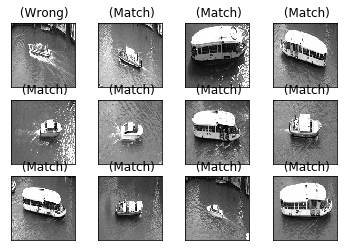

In [12]:
%matplotlib inline
fig = plt.figure()
for num, data in enumerate(testing_data[:12]):
    img_data2plot = data[0]
    img_label2plot = data[1]
    v = fig.add_subplot(3, 4, num+1)
    #v = fig.add_subplot(2, 2, num+1)
    orig = img_data2plot
    data = img_data2plot.reshape(IMG_WIDTH, IMG_HEIGHT, 1)

    if np.argmax(img_label2plot) == 0: img_truelabel = "Mototopo"
    elif np.argmax(img_label2plot) == 1: img_truelabel = "VaporettoACTV"
    else: img_truelabel = "Lanciafino10mBianca"

    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 0: str_label = "Mototopo"
    elif np.argmax(model_out) == 1: str_label = "VaporettoACTV"
    else: str_label = "Lanciafino10mBianca"

    print("Model Predicts This image to be of class: {}".format(str_label))
    print("The Correct Label is:  {}".format(img_truelabel))
    if str_label == img_truelabel: flag = " (Match)"
    else: flag = " (Wrong)"
    #cv2.imshow('Model: ' + str_label + ' Truth: ' + img_truelabel,orig)
    #cv2.waitKey(0)
    v.imshow(orig, cmap='gray')
    plt.title(flag)
    v.axes.get_xaxis().set_visible(False)
    v.axes.get_yaxis().set_visible(False)
predicted = list()
truth = list()

for the_img, the_img_label in testing_data:
    
    if np.argmax(the_img_label) == 0: img_truelabel = "Mototopo"
    elif np.argmax(the_img_label) == 1: img_truelabel = "VaporettoACTV"
    elif np.argmax(the_img_label) == 2: img_truelabel = "Lanciafino10mBianca"
    
    the_image = the_img.reshape(IMG_WIDTH, IMG_HEIGHT, 1)
    model_out = model.predict([the_image])[0]
    if np.argmax(model_out) == 0: str_label = "Mototopo"
    elif np.argmax(model_out) == 1: str_label = "VaporettoACTV"
    elif np.argmax(model_out) == 2: str_label = "Lanciafino10mBianca"
    
    if str_label == img_truelabel: flag = " (Match)"
    else: flag = " (Wrong)"
    #print(flag)

    predicted.append(str_label)
    truth.append(img_truelabel)
    
#print(len(truth))
#print(len(predicted))

confusion_matrix(truth, predicted)

In [11]:
predicted = list()
truth = list()

for the_img, the_img_label in testing_data:
    
    if np.argmax(the_img_label) == 0: img_truelabel = "Mototopo"
    elif np.argmax(the_img_label) == 1: img_truelabel = "VaporettoACTV"
    elif np.argmax(the_img_label) == 2: img_truelabel = "Lanciafino10mBianca"
    
    the_image = the_img.reshape(IMG_WIDTH, IMG_HEIGHT, 1)
    model_out = model.predict([the_image])[0]
    if np.argmax(model_out) == 0: str_label = "Mototopo"
    elif np.argmax(model_out) == 1: str_label = "VaporettoACTV"
    elif np.argmax(model_out) == 2: str_label = "Lanciafino10mBianca"
    
    if str_label == img_truelabel: flag = " (Match)"
    else: flag = " (Wrong)"
    #print(flag)

    predicted.append(str_label)
    truth.append(img_truelabel)
    
#print(len(truth))
#print(len(predicted))

confusion_matrix(truth, predicted)

array([[197,   6,  14],
       [  2, 321,   2],
       [ 13,   2, 259]])